In [1]:
import torchvision
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('./', train=True, transform=train_transform, download=True)
valid_dataset = torchvision.datasets.MNIST('./', train=False, transform=valid_transform, download=True)

train_data = train_dataset.train_data # 60000 x 28 x 28
train_label = train_dataset.train_labels # 60000

valid_data = valid_dataset.test_data # 10000 x 28 x 28
valid_label = valid_dataset.test_labels # 10000

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            # input 1x28x28
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(4),
            nn.LeakyReLU(),
            # 4x14x14
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            # 8x7x7
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            # 16x4x4
            nn.Flatten()
            # output 1x256
        )

        self.mu_layer = nn.Sequential(
            nn.Linear(in_features=256, out_features=64),
            nn.Linear(in_features=64, out_features=16),
            nn.Linear(in_features=16, out_features=2)
        )

        self.std_layer = nn.Sequential(
            nn.Linear(in_features=256, out_features=64),
            nn.Linear(in_features=64, out_features=16),
            nn.Linear(in_features=16, out_features=2)
        )

        self.z_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.Linear(in_features=16, out_features=64),
            nn.Linear(in_features=64, out_features=256)
        )

        #convTranpose output dim = (dim_in - 1) x stride - 2 x padding + dilation x (kernel_size - 1)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (16, 4, 4)),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
            # output 1x28x28
        )

    def forward(self, x):
        x = self.encode(x)
        mu = self.mu_layer(x)
        std = self.std_layer(x)

        z = self.reparameterize(mu, std)
        z = self.z_layer(z)

        x = self.decode(z)

        return x, mu, std

    def reparameterize(self, mu, std):

        e = torch.normal(0, 1, size=mu.size()).cuda()
        z = mu + e * std
        return z
    
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

def loss_func(input, output, mu, std):
    marginal_likelihood = torch.mean(torch.sum(input * torch.log(output) + (1-input) * torch.log(1-output), dim=(1, 2, 3)))

    kl_divergence = torch.mean(-0.5 * torch.sum((1 + torch.log(torch.square(std))) - torch.square(mu) - torch.square(std), dim=(1)))
    ELBO = marginal_likelihood - kl_divergence
    loss = -ELBO

    return loss

In [6]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters())
schedular = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=100, shuffle=False)
epoch_size = 20

epoch 0 : 236.92844985961915 / lr : 0.001
epoch 1 : 175.15328425089518 / lr : 0.000976
epoch 2 : 170.01170366923014 / lr : 0.000905
epoch 3 : 166.76819241841633 / lr : 0.000796
epoch 4 : 164.7902729288737 / lr : 0.000658
epoch 5 : 163.58079221089682 / lr : 0.000505
epoch 6 : 162.70324915568034 / lr : 0.000352
epoch 7 : 162.0774310048421 / lr : 0.000214
epoch 8 : 161.7072519938151 / lr : 0.000105
epoch 9 : 161.46320032755534 / lr : 3.4e-05
epoch 10 : 161.36815625508626 / lr : 1e-05
epoch 11 : 161.37613362630208 / lr : 3.4e-05
epoch 12 : 161.42488410949707 / lr : 0.000105
epoch 13 : 161.4008945465088 / lr : 0.000214
epoch 14 : 161.39003896077475 / lr : 0.000352
epoch 15 : 161.2790215555827 / lr : 0.000505
epoch 16 : 161.18972600301106 / lr : 0.000658
epoch 17 : 161.03527211507162 / lr : 0.000796
epoch 18 : 160.82461530049642 / lr : 0.000905
epoch 19 : 160.59948707580565 / lr : 0.000976


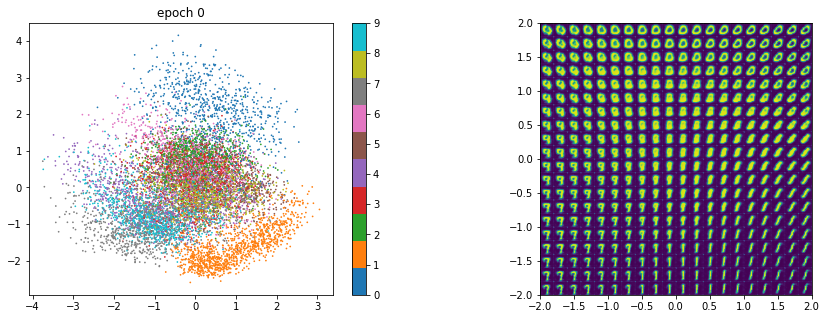

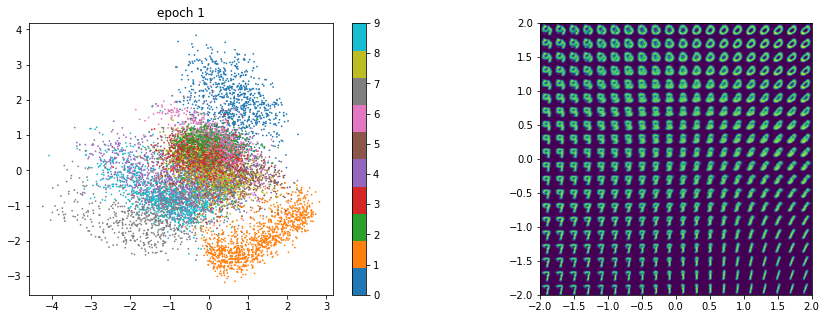

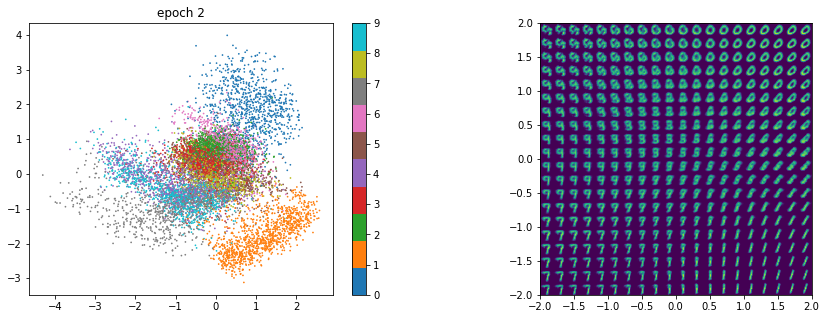

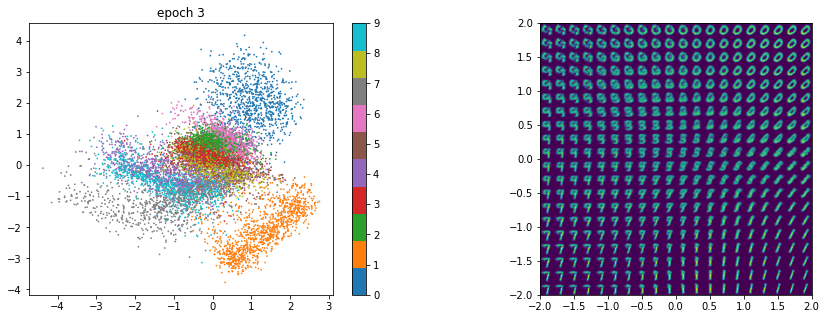

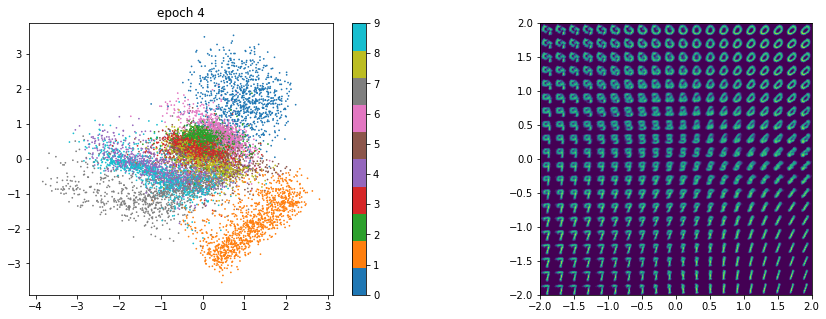

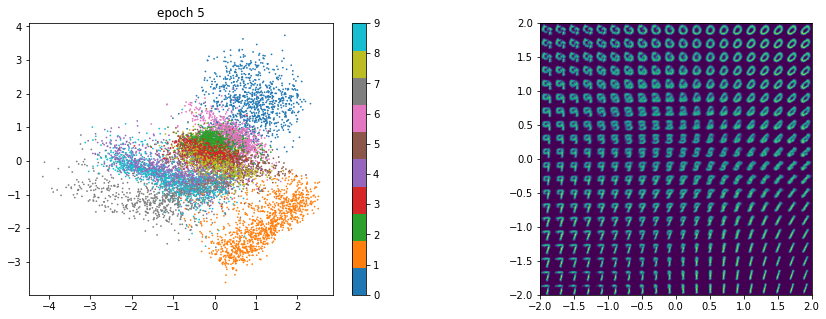

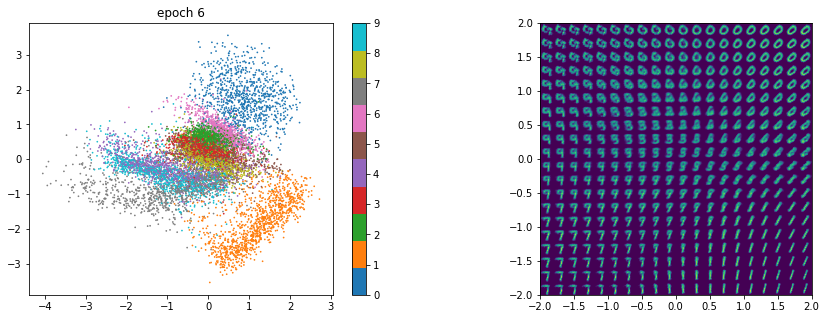

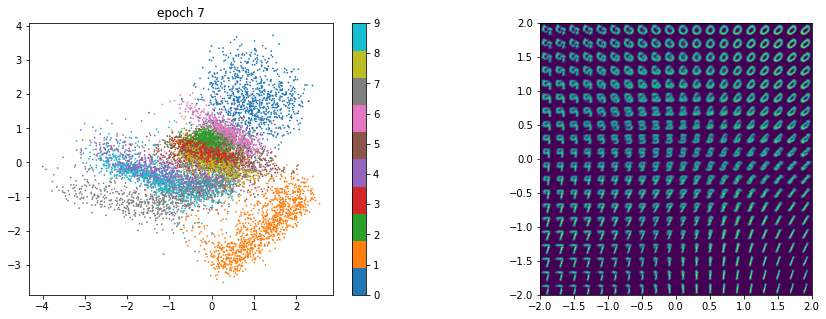

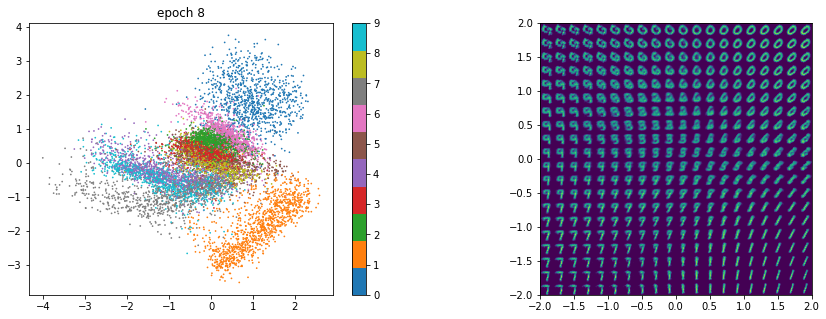

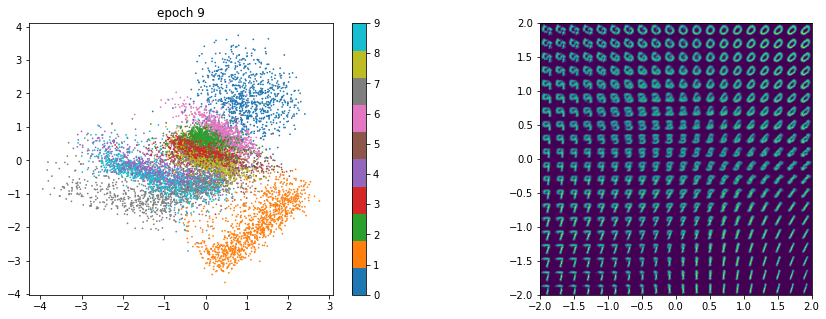

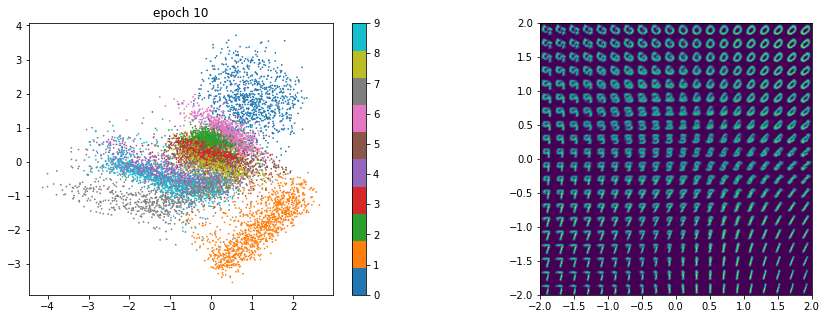

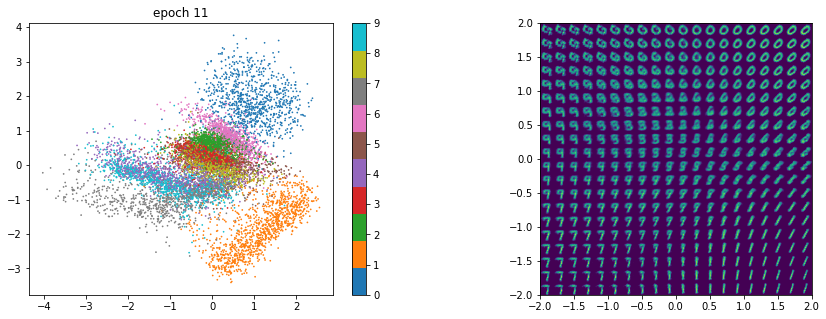

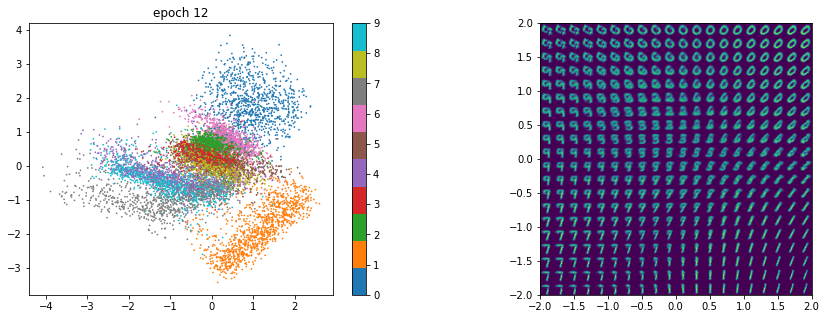

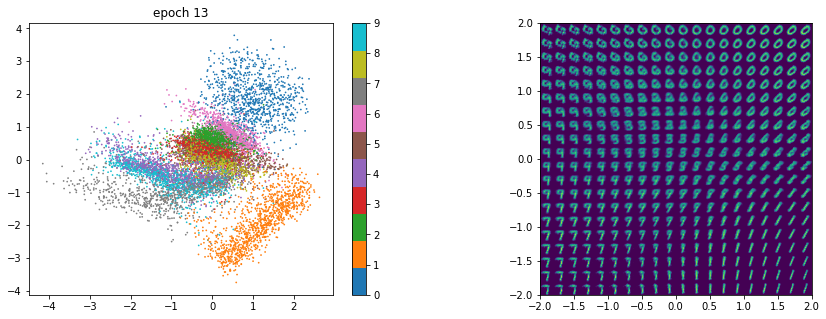

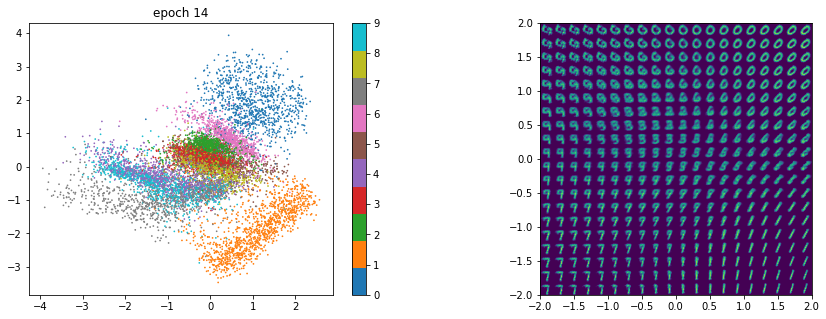

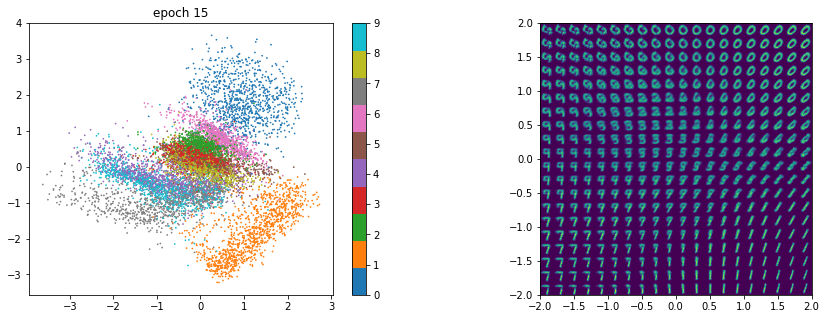

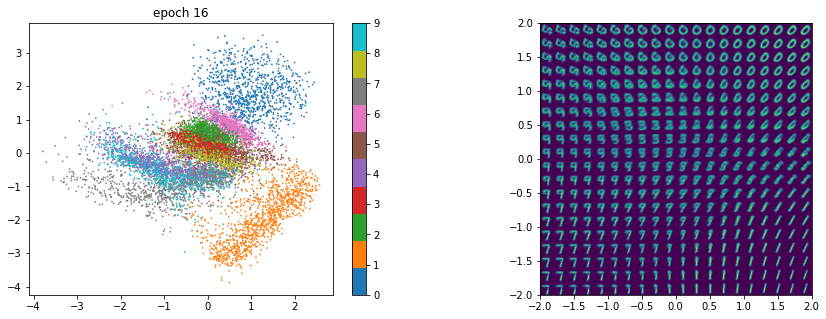

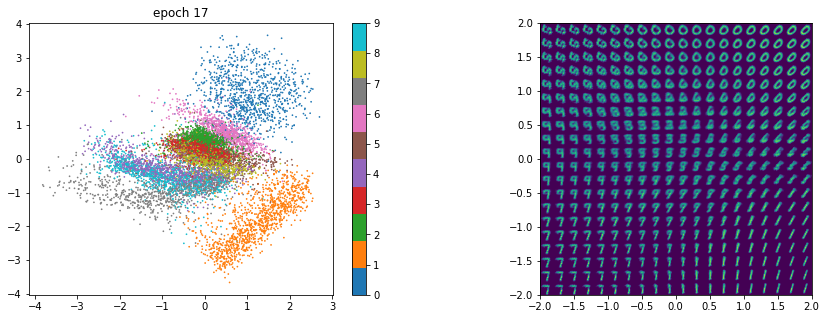

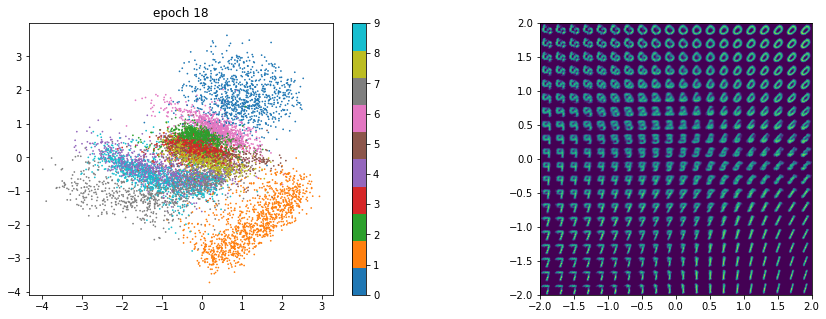

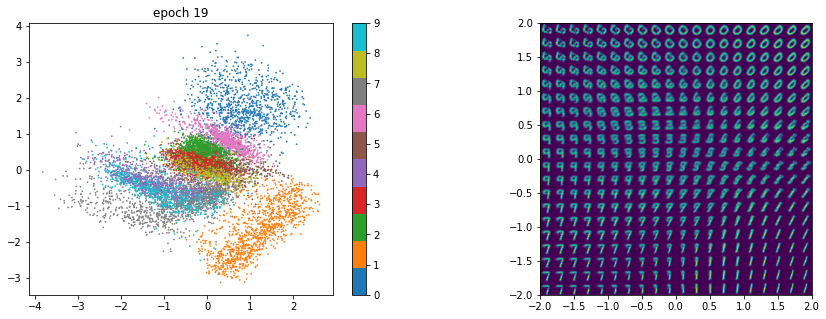

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()
model.to(device)
%matplotlib inline

for epoch_i in range(epoch_size):
    epoch_loss = []
    for batch_idx, batch_sample in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch_sample[0].to(device)
        x, mu, std = model(data) #NCHW #60000x 28 x 28

        loss = loss_func(input=data, output=x, mu=mu, std=std)
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch_i} : {np.mean(epoch_loss)} / lr : {round(schedular.get_last_lr()[0],6)}")
    schedular.step()

    model.eval()
    _x_list = []
    _y_list = []
    _label_list = []
    for batch_idx, batch_sample in enumerate(valid_loader):
        data = batch_sample[0].to(device)
        x, mu, std = model(data)
        z = model.reparameterize(mu, std)
        label = batch_sample[1]

        z = z.detach().cpu().numpy()
        _x_list.extend(z[:, 0])
        _y_list.extend(z[:, 1])
        _label_list.extend(label.detach().cpu().numpy())

    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.title(f'epoch {epoch_i}')
    plt.scatter(_x_list, _y_list, s=0.5, c=_label_list, cmap='tab10')

    plt.colorbar()
    plt_img = np.zeros((28*20, 28*20))
    x_iter = np.linspace(-2, 2, 20)
    y_iter = np.linspace(2, -2, 20)
    for x_i, _x in enumerate(x_iter):
        for y_i, _y in enumerate(y_iter):
            z = model.z_layer(torch.Tensor([_x, _y]).unsqueeze(0).cuda())
            _img = model.decode(z)
            plt_img[28 * y_i:28*(y_i + 1), 28 * x_i:28 * (x_i + 1)] = _img[0][0].detach().cpu().numpy()

    plt.subplot(122)
    plt.imshow(plt_img, extent=[-2, 2, -2, 2])